In [15]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
from iminuit import Minuit
from pprint import pprint
from scipy.special import beta
from scipy.misc import derivative
import scipy.integrate as integrate

# Load

In [16]:
NNPDF = pd.read_table('../results/NNPDF30_NNLO_Q2=1.117.dat', skiprows = 1, header = 0, engine = 'python', sep = '  ', index_col=False)
CT14 = pd.read_table('../results/CT14_NNLO_Q2=1.117.dat', skiprows = 1, header = 0, engine = 'python', sep = '  ', index_col=False)
MMHT14 = pd.read_table('../results/MMHT2014_NNLO_Q2=1.117.dat', skiprows = 1, header = 0, engine = 'python', sep = '  ', index_col=False)

# Functions

In [138]:
class LFHQCD:
    kappa = 0.533663
    a0rho = 0.492113
    a0omega = 0.5
    a0phi = 0.014219
    a0 = 0.5 - 0.1349770**2 / (4.0 * kappa**2)
    mup = 2.7928473446
    kap = mup - 1.0
    mun = -1.9130427
    kan = mun
    Mp = 0.938272081
    Mn = 0.939565413
    kau = 2.0 * kap + kan
    kad = kap + 2.0 * kan
    Mpi = 0.1349770
    a0P = 1.09
    atP = 0.25
    
    a3 = 1.6885782279344626
    a4 = 3.749396855067173e-16
    a5 = 0.3114217720655371
    a6 = -1.3829904868669063e-16
    b3 = 1.4997587420268692e-15
    b4 = 0.8442891139672299
    b5 = -0.15571052354227843
    b6 = 0.31142140957504694
    
    u3 = a3
    u4 = a4
    d3 = b3
    d4 = b4
    
    u5 = a5
    u6 = 0
    ub5 = 0
    ub6 = 0
    
    d5 = 0
    d6 = b6
    db5 = -b5
    db6 = 0
    
    g4 = 1.0
    g5 = 0.0
    
    a = 0.363
    def __int__(self):
        pass
    
    def w(self, x):
        return x**(1.0 - x) * np.exp(-self.a * (1.0-x)**2)
        #return self.a * x + (3 - 2.0 * self.a) * x**2 + (self.a - 2) * x**3
    
    def dw(self, x):
        return x**(-x) * np.exp(-self.a * (1.0 - x)**2) * ((1.0 - x) * (1.0 + 2.0 * self.a * x) - x * np.log(x))
        #return self.a + 2.0 * (3.0 - 2.0 * self.a) * x + 3.0 * (self.a - 2) * x**2
    
    def qx(self, x, tau):
        return (self.w(x)**(-self.a0) * (1.0 - self.w(x))**(tau - 2) * self.dw(x)) / beta(tau - 1.0, 1.0 - self.a0)

    def xqx(self, x, tau):
        return x * self.qx(x, tau)
    
    def qx_M1(self, tau):
        return integrate.quad(self.xqx, 0, 1, args = tau)[0]
    
    def uv(self, x):
        return self.a3 * self.qx(x, 3) + self.a4 * self.qx(x, 4) + self.a5 * self.qx(x, 5) + self.a6 * self.qx(x, 6)
    
    def dv(self, x):
        return self.b3 * self.qx(x, 3) + self.b4 * self.qx(x, 4) + self.b5 * self.qx(x, 5) + self.b6 * self.qx(x, 6)  

    def xu(self, x):
        return self.u3 * self.xqx(x, 3) + self.u4 * self.xqx(x, 4) + self.u5 * self.xqx(x, 5) + self.u6 * self.xqx(x, 6)
    
    def xub(self, x):
        return self.ub5 * self.xqx(x, 5) + self.ub6 * self.xqx(x, 6)
    
    def xd(self, x):
        return self.d3 * self.xqx(x, 3) + self.d4 * self.xqx(x, 4) + self.d5 * self.xqx(x, 5) + self.d6 * self.xqx(x, 6)
    
    def xdb(self, x):
        return self.db5 * self.xqx(x, 5) + self.db6 * self.xqx(x, 6)
    
    def xuv(self, x):
        return x * self.uv(x)
    
    def xdv(self, x):
        return x * self.dv(x)
    
    def uv_M1(self):
        return integrate.quad(self.xuv, 0, 1)[0]
    
    def dv_M1(self):
        return integrate.quad(self.xdv, 0, 1)[0]
    
    def gx(self, x, tau):
        return (self.w(x)**(-self.a0P) * (1.0 - self.w(x))**(tau - 2) * self.dw(x))
    
    def gluon(self, x):
        return self.g4 * self.gx(x, 4) + self.g5 * self.gx(x, 5)
    
    def xgluon(self, x):
        return x * self.gluon(x)
    
    def gluon_M1(self):
        return integrate.quad(self.xgluon, 0, 1)[0]

# PDF

In [147]:
lfhqcd = LFHQCD()

In [148]:
lfhqcd.a0

0.48400716838522223

## check

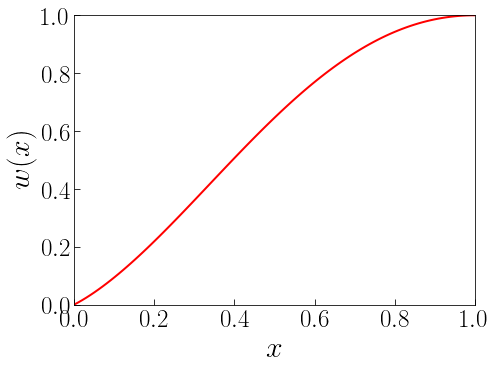

In [108]:
nrows, ncols = 1, 1

fig = plt.figure(figsize = (ncols * 7, nrows * 7 * 0.75))

ax = fig.add_subplot(nrows, ncols, 1)
X = np.linspace(0, 1, 100)
ax.plot(X, lfhqcd.w(X), color = 'red', linewidth = 2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$x$', size = 30)
ax.set_ylabel(r'$w(x)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', length = 6, labelsize = 25)

fig.tight_layout()

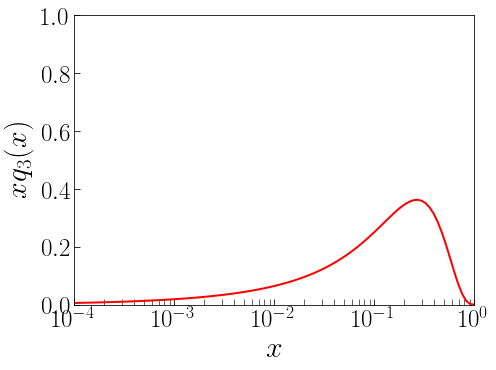

In [109]:
nrows, ncols = 1, 1

fig = plt.figure(figsize=(ncols * 7, nrows * 7 * 0.75))
ax = fig.add_subplot(nrows, ncols, 1)
X = 10**np.linspace(-4, 0, 100)
ax.plot(X, X * lfhqcd.qx(X, 3), color = 'red', linewidth = 2)
ax.set_xlim(1e-4, 1)
ax.set_ylim(0, 1)
ax.set_xscale('log')
ax.set_xlabel(r'$x$', size = 30)
ax.set_ylabel(r'$xq_3(x)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', length = 6, labelsize = 25)

fig.tight_layout()

## Fit valence

In [118]:
def chi2(par):
    lfhqcd.a = par[0]
    M1uv = (0.2946 + 0.3431 + 0.3390) / 3
    M1dv = (0.1204 + 0.1447 + 0.1418) / 3
    return (lfhqcd.uv_M1() - M1uv)**2 + (lfhqcd.dv_M1() - M1dv)**2

In [119]:
Min = Minuit.from_array_func(chi2, start = (0.5, ),\
                             name = ('a', ),\
                             error = (0.0001, ),\
                             errordef = 1,\
                             fix = (False, ),\
                             limit = (None, ))

In [120]:
Min.print_level = 1
fmin, fpar = Min.migrad(ncall=100000)

FCN = 0.000207750302314 
 TOTAL NCALL = 15 
 NCALLS = 15 
 
 
 EDM = 2.42407248854e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,0.363904,6.60506,,,,,No


In [121]:
lfhqcd.a = Min.values['a']

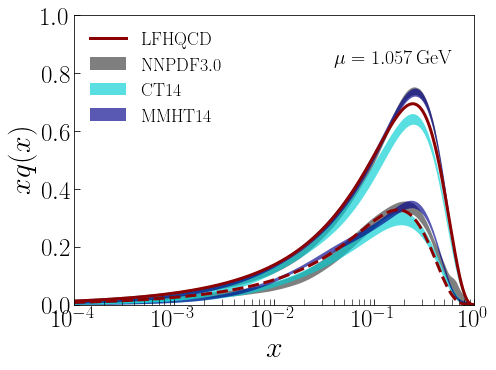

In [144]:
nrows, ncols = 1, 1

fig = plt.figure(figsize = (ncols * 7, nrows * 7 * 0.75))
ax = fig.add_subplot(nrows, ncols, 1)
X = 10**np.linspace(-4, 0, 500)
c1u = ax.fill_between(NNPDF['x'], NNPDF['xuv']+NNPDF['Exuv'], NNPDF['xuv']-NNPDF['Exuv'],\
                   color = 'dimgray', alpha = 0.85, linewidth = 0)
c1d = ax.fill_between(NNPDF['x'], NNPDF['xdv']+NNPDF['Exdv'], NNPDF['xdv']-NNPDF['Exdv'],\
                   color = 'dimgray', alpha = 0.85, linewidth = 0)
c2u = ax.fill_between(CT14['x'], CT14['xuv']+CT14['Exuv'], CT14['xuv']-CT14['Exuv'],\
                   color = 'darkturquoise', alpha = 0.65, linewidth = 0)
c2d = ax.fill_between(CT14['x'], CT14['xdv']+CT14['Exdv'], CT14['xdv']-CT14['Exdv'],\
                   color = 'darkturquoise', alpha = 0.65, linewidth = 0)
c3u = ax.fill_between(MMHT14['x'], MMHT14['xuv']+MMHT14['Exuv'], MMHT14['xuv']-MMHT14['Exuv'],\
                   color = 'darkblue', alpha = 0.65, linewidth = 0, label = r'$\rm MMHT14$')
c3d = ax.fill_between(MMHT14['x'], MMHT14['xdv']+MMHT14['Exdv'], MMHT14['xdv']-MMHT14['Exdv'],\
                   color = 'darkblue', alpha = 0.65, linewidth = 0)
c0u = ax.plot(X, lfhqcd.xuv(X), color = 'darkred', linewidth = 3, linestyle = '-')
c0d = ax.plot(X, lfhqcd.xdv(X), color = 'darkred', linewidth = 3, linestyle = '--')
ax.set_xlim(1e-4, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$x$', size=30)
ax.set_ylabel(r'$xq(x)$', size=30)
ax.set_xscale('log')
ax.tick_params(axis='both', which = 'both', direction = 'in', length = 6, labelsize = 25)
L = [(c0u[0]), c1u, c2u, c3u]
H = [r'$\rm LFHQCD$', r'$\rm NNPDF3.0$', r'$\rm CT14$', r'$\rm MMHT14$']
ax.legend(L, H, frameon = False, loc = 'upper left', fontsize = 18)
ax.text(0.65, 0.85, r'$\rm \mu=1.057\,GeV$', transform = ax.transAxes, horizontalalignment = 'left', verticalalignment = 'center', size = 20)

fig.tight_layout()
fig.savefig('plots/valencepdf.pdf')

## Sea

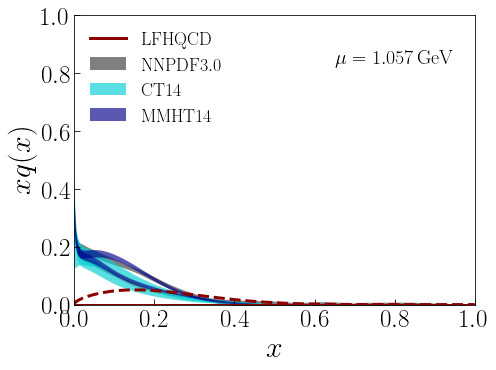

In [146]:
nrows, ncols = 1, 1

fig = plt.figure(figsize = (ncols * 7, nrows * 7 * 0.75))
ax = fig.add_subplot(nrows, ncols, 1)
X = 10**np.linspace(-4, 0, 500)
c1u = ax.fill_between(NNPDF['x'], NNPDF['xub']+NNPDF['Exub'], NNPDF['xub']-NNPDF['Exub'],\
                   color = 'dimgray', alpha = 0.85, linewidth = 0)
c1d = ax.fill_between(NNPDF['x'], NNPDF['xdb']+NNPDF['Exdb'], NNPDF['xdb']-NNPDF['Exdb'],\
                   color = 'dimgray', alpha = 0.85, linewidth = 0)
c2u = ax.fill_between(CT14['x'], CT14['xub']+CT14['Exub'], CT14['xub']-CT14['Exub'],\
                   color = 'darkturquoise', alpha = 0.65, linewidth = 0)
c2d = ax.fill_between(CT14['x'], CT14['xdb']+CT14['Exdb'], CT14['xdb']-CT14['Exdb'],\
                   color = 'darkturquoise', alpha = 0.65, linewidth = 0)
c3u = ax.fill_between(MMHT14['x'], MMHT14['xub']+MMHT14['Exub'], MMHT14['xub']-MMHT14['Exub'],\
                   color = 'darkblue', alpha = 0.65, linewidth = 0, label = r'$\rm MMHT14$')
c3d = ax.fill_between(MMHT14['x'], MMHT14['xdb']+MMHT14['Exdb'], MMHT14['xdb']-MMHT14['Exdb'],\
                   color = 'darkblue', alpha = 0.65, linewidth = 0)
c0u = ax.plot(X, lfhqcd.xub(X), color = 'darkred', linewidth = 3, linestyle = '-')
c0d = ax.plot(X, lfhqcd.xdb(X), color = 'darkred', linewidth = 3, linestyle = '--')
ax.set_xlim(1e-4, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$x$', size=30)
ax.set_ylabel(r'$xq(x)$', size=30)
#ax.set_xscale('log')
ax.tick_params(axis='both', which = 'both', direction = 'in', length = 6, labelsize = 25)
L = [(c0u[0]), c1u, c2u, c3u]
H = [r'$\rm LFHQCD$', r'$\rm NNPDF3.0$', r'$\rm CT14$', r'$\rm MMHT14$']
ax.legend(L, H, frameon = False, loc = 'upper left', fontsize = 18)
ax.text(0.65, 0.85, r'$\rm \mu=1.057\,GeV$', transform = ax.transAxes, horizontalalignment = 'left', verticalalignment = 'center', size = 20)

fig.tight_layout()
#fig.savefig('plots/seapdf.pdf')

## Gluon

In [53]:
def gluon(x, a):
    return gx(x, a, 4)

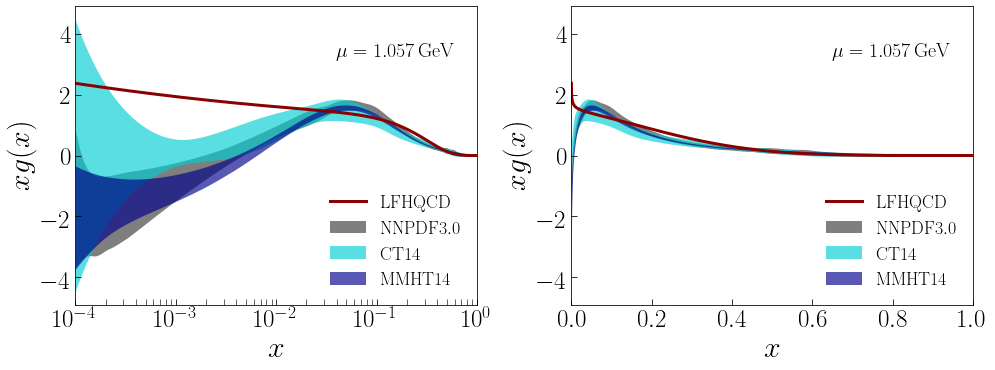

In [142]:
nrows, ncols = 1, 2

fig = plt.figure(figsize = (ncols * 7, nrows * 7 * 0.75))
ax = fig.add_subplot(nrows, ncols, 1)
X = 10**np.linspace(-4, 0, 500)
c1 = ax.fill_between(NNPDF['x'], NNPDF['xg']+NNPDF['Exg'], NNPDF['xg']-NNPDF['Exg'],\
                   color = 'dimgray', alpha = 0.85, linewidth = 0)
c2 = ax.fill_between(CT14['x'], CT14['xg']+CT14['Exg'], CT14['xg']-CT14['Exg'],\
                   color = 'darkturquoise', alpha = 0.65, linewidth = 0)
c3 = ax.fill_between(MMHT14['x'], MMHT14['xg']+MMHT14['Exg'], MMHT14['xg']-MMHT14['Exg'],\
                   color = 'darkblue', alpha = 0.65, linewidth = 0, label = r'$\rm MMHT14$')
c0 = ax.plot(X, lfhqcd.xgluon(X), color = 'darkred', linewidth = 3, linestyle = '-')
ax.set_xlim(1e-4, 1)
#ax.set_ylim(0, 1)
ax.set_xlabel(r'$x$', size=30)
ax.set_ylabel(r'$xg(x)$', size=30)
ax.set_xscale('log')
ax.tick_params(axis='both', which = 'both', direction = 'in', length = 6, labelsize = 25)
L = [(c0[0]), c1, c2, c3]
H = [r'$\rm LFHQCD$', r'$\rm NNPDF3.0$', r'$\rm CT14$', r'$\rm MMHT14$']
ax.legend(L, H, frameon = False, loc = 'lower right', fontsize = 18)
ax.text(0.65, 0.85, r'$\rm \mu=1.057\,GeV$', transform = ax.transAxes, horizontalalignment = 'left', verticalalignment = 'center', size = 20)

ax = fig.add_subplot(nrows, ncols, 2)
X = 10**np.linspace(-4, 0, 500)
c1 = ax.fill_between(NNPDF['x'], NNPDF['xg']+NNPDF['Exg'], NNPDF['xg']-NNPDF['Exg'],\
                   color = 'dimgray', alpha = 0.85, linewidth = 0)
c2 = ax.fill_between(CT14['x'], CT14['xg']+CT14['Exg'], CT14['xg']-CT14['Exg'],\
                   color = 'darkturquoise', alpha = 0.65, linewidth = 0)
c3 = ax.fill_between(MMHT14['x'], MMHT14['xg']+MMHT14['Exg'], MMHT14['xg']-MMHT14['Exg'],\
                   color = 'darkblue', alpha = 0.65, linewidth = 0, label = r'$\rm MMHT14$')
c0 = ax.plot(X, lfhqcd.xgluon(X), color = 'darkred', linewidth = 3, linestyle = '-')
ax.set_xlim(1e-4, 1)
#ax.set_ylim(0, 1)
ax.set_xlabel(r'$x$', size=30)
ax.set_ylabel(r'$xg(x)$', size=30)
ax.tick_params(axis='both', which = 'both', direction = 'in', length = 6, labelsize = 25)
L = [(c0[0]), c1, c2, c3]
H = [r'$\rm LFHQCD$', r'$\rm NNPDF3.0$', r'$\rm CT14$', r'$\rm MMHT14$']
ax.legend(L, H, frameon = False, loc = 'lower right', fontsize = 18)
ax.text(0.65, 0.85, r'$\rm \mu=1.057\,GeV$', transform = ax.transAxes, horizontalalignment = 'left', verticalalignment = 'center', size = 20)


fig.tight_layout()
fig.savefig('plots/gluonpdf.pdf')